Bottleneck features

In [2]:
import os, os.path
train_dir = r'D:\Docs\Python_code\DogHotDogNotDog\Data\Train_data'
folder_list = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
print(folder_list)

samples = 0
train_samples = 0
for item in folder_list:
    samples = len([name for name in os.listdir(train_dir+'\\'+item) 
                     if os.path.isfile(os.path.join(train_dir+'\\'+item, name))])
    train_samples += samples
    print(item, samples) 

['cute_dog', 'hot_dog', 'not_dog']
cute_dog 1004
hot_dog 810
not_dog 807


In [3]:
val_dir = 'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data'
samples = 0
val_samples = 0
for item in folder_list:
    samples = len([name for name in os.listdir(val_dir+'\\'+item) 
                     if os.path.isfile(os.path.join(val_dir+'\\'+item, name))])
    val_samples += samples
    print(item, samples)

cute_dog 214
hot_dog 215
not_dog 226


In [17]:
from keras import backend as K
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.models import Model
import numpy as np

batch_size = 32
img_width, img_height = 150, 150
channels = 3
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'D:\Docs\Python_code\DogHotDogNotDog\Data\Train_data'
validation_data_dir = 'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data'
nb_train_samples = train_samples #2000
nb_validation_samples = val_samples #800
epochs = 50

def save_bottlebeck_features():
    datagen = ImageDataGenerator(samplewise_std_normalization=True)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    
    train_labels = generator.classes
#     generator = datagen.flow(train_Images, dummy_y_train, batch_size=batch_size, 
#                                       shuffle=False, sample_weight=None, seed=None, 
#                                       save_to_dir=None, save_prefix='', save_format='jpg', subset=None)
    
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
#     generator = datagen.flow(val_Images, dummy_y_val, batch_size=batch_size, 
#                                       shuffle=False, sample_weight=None, seed=None, 
#                                       save_to_dir=None, save_prefix='', save_format='jpg', subset=None)
    
    val_labels = generator.classes
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)
    
    return train_labels, val_labels

In [40]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_top_model(train_labels, val_labels):
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_labels = train_labels[:len(train_data)]
    #train_labels = dummy_y_train[:len(train_data)] #np.array(
        #[0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))
    train_binary = to_categorical(train_labels)
    
    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    validation_labels = val_labels[:len(validation_data)] #dummy_y_val[:len(validation_data)] #np.array(
        #[0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))
    val_binary = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, 
                                 save_best_only=True, mode='auto', period=1)
    model.fit(train_data, train_binary,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, val_binary),
              callbacks = [early_stop, checkpoint])
    
        # serialize model to JSON
    model_json = model.to_json()
    with open("bottleneck_fc_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("bottleneck_fc_model_weights.h5")
    print("Saved model to disk")

In [15]:
train_labels, val_labels = save_bottlebeck_features()

Found 2621 images belonging to 3 classes.


C:\Users\Robin\Anaconda3\envs\HotDog\lib\site-packages\PIL\Image.py:965: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


Found 655 images belonging to 3 classes.


In [41]:
train_top_model(train_labels, val_labels)

Train on 2592 samples, validate on 640 samples
Epoch 1/50
2592/2592 [==============================] - 1s 511us/step - loss: 0.4976 - acc: 0.8171 - val_loss: 0.2241 - val_acc: 0.9094

Epoch 00001: val_acc improved from -inf to 0.90938, saving model to bottleneck_fc_model.h5
Epoch 2/50
2592/2592 [==============================] - 1s 225us/step - loss: 0.1609 - acc: 0.9348 - val_loss: 0.2790 - val_acc: 0.9094

Epoch 00002: val_acc did not improve from 0.90938
Epoch 3/50
2592/2592 [==============================] - 1s 222us/step - loss: 0.0721 - acc: 0.9757 - val_loss: 0.2984 - val_acc: 0.9062

Epoch 00003: val_acc did not improve from 0.90938
Epoch 4/50
2592/2592 [==============================] - 1s 224us/step - loss: 0.0320 - acc: 0.9938 - val_loss: 0.3241 - val_acc: 0.9172

Epoch 00004: val_acc improved from 0.90938 to 0.91719, saving model to bottleneck_fc_model.h5
Epoch 5/50
2592/2592 [==============================] - 1s 223us/step - loss: 0.0220 - acc: 0.9942 - val_loss: 0.2448 - 

In [43]:
#Prediction
from keras.models import model_from_json

# load json and create model
json_file = open('bottleneck_fc_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("bottleneck_fc_model_weights.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(samplewise_std_normalization=True)

validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
validation_labels = val_labels[:len(validation_data)] #dummy_y_val[:len(validation_data)] #np.array(
    #[0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))
val_binary = to_categorical(validation_labels)

probabilities = loaded_model.predict(
        validation_data, val_samples // batch_size)

Loaded model from disk
Found 655 images belonging to 3 classes.


In [44]:
from sklearn.metrics import confusion_matrix

y_pred = probabilities > 0.5
y_true = val_binary[:len(y_pred)]

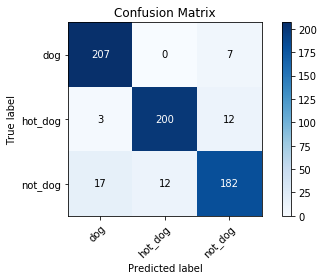

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
classes = ['dog', 'hot_dog', 'not_dog']
cmap=plt.cm.Blues
title = 'Confusion Matrix'
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [107]:
labels = {'cute_dog': [True, False, False],
          'hot_dog': [False, True, False],
          'not_dog': [False, False, True]}

In [108]:
# function to return key for any value 
def get_key(val): 
    for key, value in labels.items(): 
         if val == value: 
             return key 
  
    return "key doesn't exist"

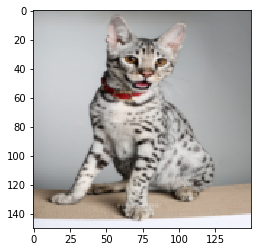

[False, False, True]
not_dog


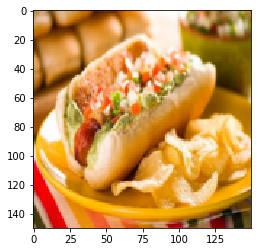

[False, True, False]
hot_dog


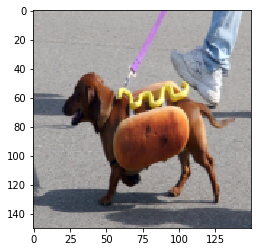

[True, False, False]
cute_dog


In [109]:
from skimage.io import imread
from skimage.transform import resize
from skimage import img_as_float

datagen = ImageDataGenerator(samplewise_std_normalization=True)

test_img = [r'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data\not_dog\cat_113.jpg',
           r'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data\hot_dog\00278daefc554ad29c6bae54e0a5c4ca.jpg',
           r'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data\cute_dog\dog hotdog_99.jpg']

for _ in test_img:

    img = imread(_)

    img = resize(img, (img_height,img_width,channels), mode='reflect', anti_aliasing=True)

    plt.imshow(img)
    plt.show()

    test_Image = img_as_float(datagen.standardize(img))
    new_test = test_Image.reshape((1,) + test_Image.shape) 

    VGG16_model = applications.VGG16(include_top=False, weights='imagenet')
    bottleneck_test = VGG16_model.predict(new_test)


    prediction = loaded_model.predict(bottleneck_test)
    val = (prediction > 0.5).tolist()[0]
    
    print(val)
    print(get_key(val)) 
    #print(encoder.inverse_transform(np.argmax(prediction, axis=1))) #[np.where(r==1)[0][0] for r in prediction]

In [106]:
labels.items()

dict_items([('cute_dog', [True, False, False]), ('hot_dog', [True, False, False]), ('not_dog', [True, False, False])])

In [79]:
list(prediction > 0.5) == [False, False, True]

False